<a href="https://colab.research.google.com/github/nathanschoeck/Computer-Vision/blob/main/Panorama_Stitching_using_SIFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

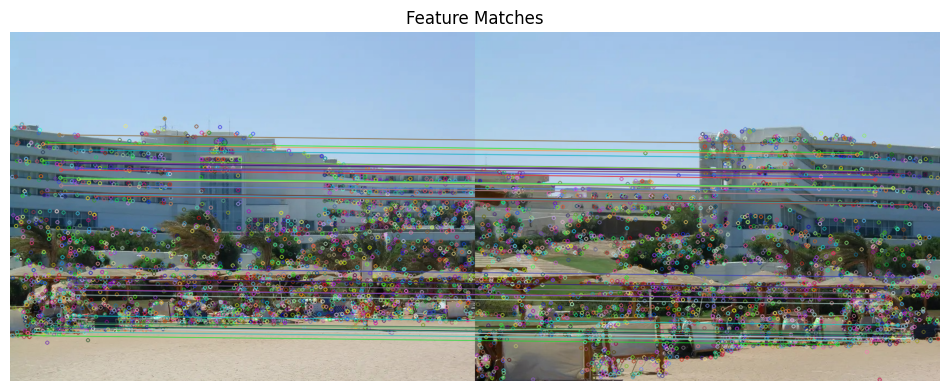

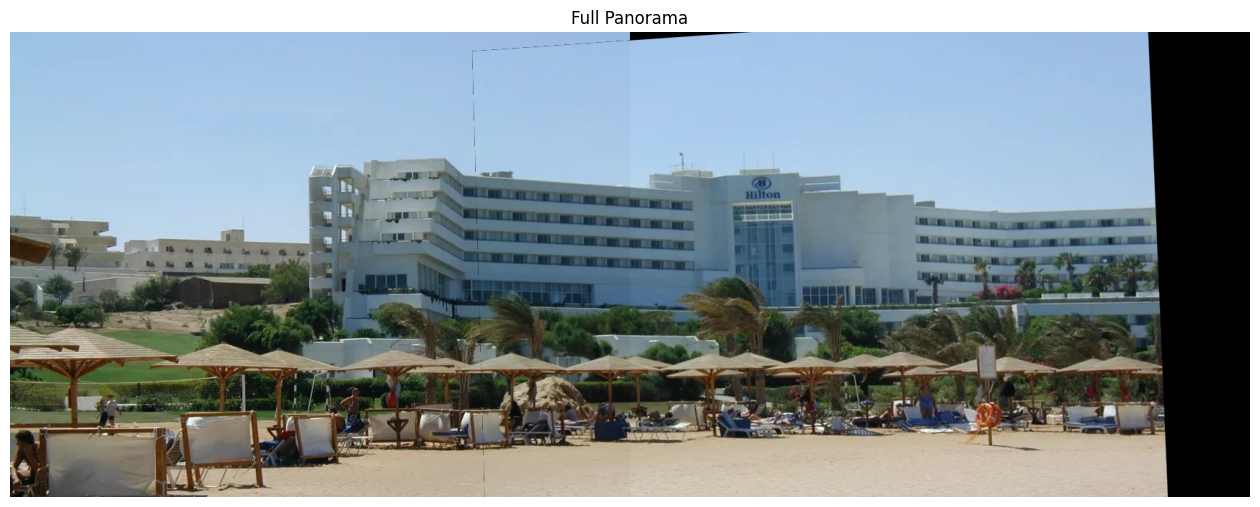

True

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def stitch_images(image1, image2):
    # Convert images to grayscale
    gray1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)

    # Initialize SIFT detector
    sift = cv2.SIFT_create()

    # Detect keypoints and compute descriptors
    keypoints1, descriptors1 = sift.detectAndCompute(gray1, None)
    keypoints2, descriptors2 = sift.detectAndCompute(gray2, None)

    # Use BFMatcher to match descriptors
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)
    matches = bf.match(descriptors1, descriptors2)

    # Sort matches by distance (best matches first)
    matches = sorted(matches, key=lambda x: x.distance)

    # Draw matches (optional visualization)
    match_img = cv2.drawMatches(image1, keypoints1, image2, keypoints2, matches[:50], None)
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
    plt.title("Feature Matches")
    plt.axis("off")
    plt.show()

    # Extract locations of matched keypoints
    src_pts = np.float32([keypoints1[m.queryIdx].pt for m in matches]).reshape(-1, 1, 2)
    dst_pts = np.float32([keypoints2[m.trainIdx].pt for m in matches]).reshape(-1, 1, 2)

    # Compute homography matrix
    homography_matrix, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

    # Warp the first image to align with the second image
    height1, width1 = image1.shape[:2]
    height2, width2 = image2.shape[:2]

    # Create a canvas large enough to fit both images
    panorama_width = width1 + width2
    panorama_height = max(height1, height2)

    # Warp the first image onto the canvas
    warped_image1 = cv2.warpPerspective(image1, homography_matrix, (panorama_width, panorama_height))

    # Place the second image onto the canvas
    panorama = warped_image1.copy()
    panorama[0:height2, 0:width2] = image2

    # Blend overlapping regions
    for y in range(height2):
        for x in range(width2):
            # If there are overlapping regions, blend them
            if np.any(warped_image1[y, x] > 0) and np.any(image2[y, x] > 0):
                panorama[y, x] = (warped_image1[y, x] * 0.5 + image2[y, x] * 0.5).astype(np.uint8)

    return panorama

# Load input images
image1_path = "/hotel2.jpg"  # Replace with your first image path
image2_path = "/hotel1.jpg"  # Replace with your second image path
image1 = cv2.imread(image1_path)
image2 = cv2.imread(image2_path)

# Stitch the images
result = stitch_images(image1, image2)

# Display the panorama
plt.figure(figsize=(16, 8))
plt.imshow(cv2.cvtColor(result, cv2.COLOR_BGR2RGB))
plt.title("Full Panorama")
plt.axis("off")
plt.show()

# Save the result
cv2.imwrite("panorama_result.jpg", result)
